In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn import metrics

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv('/content/drive/My Drive/clash/clash_data_consolidated.csv')

In [7]:
df = df.dropna()

In [ ]:
win_sample_df = df.loc[df['won']==1].sample(n=5000,random_state=42)
lose_sample_df = df.loc[df['won']==0].sample(n=5000,random_state=42)
sample_df = pd.concat([win_sample_df,lose_sample_df])

In [ ]:
import ast

sample_df['cards2_dict'] = sample_df['cards2_dict'].apply(lambda x: ast.literal_eval(x))
sample_df['deck2'] = sample_df['cards2_dict'].apply(lambda x: [a['name'] for a in x])

sample_df['cards1_dict'] = sample_df['cards1'].apply(lambda x: ast.literal_eval(x))
sample_df['deck1'] = sample_df['cards1_dict'].apply(lambda x: [a['name'] for a in x])

def merge(list1, list2):
  merged_list = [(list1[i], list2[i]) for i in range(len(list1))]
  return merged_list

sample_df['max_level_1'] = sample_df['cards1_dict'].apply(lambda x: [a['maxLevel'] for a in x])
sample_df['level_1'] = sample_df['cards1_dict'].apply(lambda x: [a['level'] for a in x])
sample_df['cards_level_1'] = [[x-y+14 for x,y in merge(sample_df['level_1'].iloc[i],sample_df['max_level_1'].iloc[i])] for i in range(len(sample_df))]
sample_df['avg_cards_level_1'] = [sum(x)/8 for x in sample_df['cards_level_1']]

sample_df['max_level_2'] = sample_df['cards2_dict'].apply(lambda x: [a['maxLevel'] for a in x])
sample_df['level_2'] = sample_df['cards2_dict'].apply(lambda x: [a['level'] for a in x])
sample_df['cards_level_2'] = [[x-y+14 for x,y in merge(sample_df['level_2'].iloc[i],sample_df['max_level_2'].iloc[i])] for i in range(len(sample_df))]
sample_df['avg_cards_level_2'] = [sum(x)/8 for x in sample_df['cards_level_2']]

sample_df['crowns_won'] = sample_df['crowns2'] - sample_df['crowns1']
sample_df['2_won'] = 0
sample_df['2_won'].loc[sample_df['crowns_won']>0] = 1
sample_df['2_won'].loc[sample_df['crowns_won']<0] = 0

sample_df.drop(['won','crowns_won','crowns1','crowns2','cards1','cards2','cards1_dict','cards2_dict','max_level_1'\
                ,'max_level_2','level_1','level_2','cards_level_1','cards_level_2','Unnamed: 0'],axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
stats_df = pd.read_excel('/content/drive/My Drive/clash/card_stats.xlsx')
stats_df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [ ]:
def how_many_A_in_B(list1,list2):
  count=0
  for item in list1:
    if item in list2:
      count+=1
  return count

In [ ]:
for card_type in list(stats_df['Detailed Cat.'].unique()):
  sample_df[card_type+'1'] = sample_df['deck1'].apply(lambda x: how_many_A_in_B(x,list(stats_df['Card'].loc[stats_df['Detailed Cat.']==card_type])))
for card_type in list(stats_df['Detailed Cat.'].unique()):
  sample_df[card_type+'2'] = sample_df['deck2'].apply(lambda x: how_many_A_in_B(x,list(stats_df['Card'].loc[stats_df['Detailed Cat.']==card_type])))

In [18]:
def eval_result(y_test,y_pred,cv_score,model_name,metric):
  print("=== Confusion Matrix ===")
  print(confusion_matrix(y_test, y_pred))
  print('\n')
  print("=== Classification Report ===")
  print(classification_report(y_test, y_pred))
  print('\n')
  print("=== All "+metric+" Scores ===")
  print(cv_score)
  print('\n')
  print("=== Mean "+metric+" Score ===")
  print("Mean "+metric+" Score - "+model_name+": ", cv_score.mean())

In [ ]:
X = sample_df.drop(['startingTrophies2','deck1','deck2','2_won'],axis=1)
y = sample_df[['2_won']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
y_pred = rfc.predict(X_test)

rfc_cv_score = cross_val_score(rfc, X, y, cv=9, scoring='roc_auc')

eval_result(y_test,y_pred,rfc_cv_score,'RF','AUC')

In [ ]:
high = sample_df.loc[(sample_df['startingTrophies2']>5500)&(sample_df['startingTrophies2']<7000)]
print("Population ratio:"+str(len(high)/len(sample_df)))
X = high.drop(['startingTrophies2','deck1','deck2','2_won'],axis=1)
y = high[['2_won']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
y_pred = rfc.predict(X_test)

rfc_cv_score = cross_val_score(rfc, X, y, cv=9, scoring='roc_auc')

eval_result(y_test,y_pred,rfc_cv_score,'RF','AUC')

Population ratio:0.5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was

=== Confusion Matrix ===
[[403 332]
 [377 388]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.52      0.55      0.53       735
           1       0.54      0.51      0.52       765

    accuracy                           0.53      1500
   macro avg       0.53      0.53      0.53      1500
weighted avg       0.53      0.53      0.53      1500



=== All AUC Scores ===
[0.56655409 0.52739389 0.56697723 0.53324922 0.54402174 0.54154979
 0.55054932 0.56857436 0.51100592]


=== Mean AUC Score ===
Mean AUC Score - RF:  0.5455417297134009


In [ ]:
mid = sample_df.loc[(sample_df['startingTrophies2']<5500) & (sample_df['startingTrophies2']>3500)]
print("Population ratio:"+str(len(mid)/len(sample_df)))
X = mid.drop(['startingTrophies2','deck1','deck2','2_won'],axis=1)
y = mid[['2_won']]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
y_pred = rfc.predict(X_test)

rfc_cv_score = cross_val_score(rfc, X, y, cv=9, scoring='roc_auc')

eval_result(y_test,y_pred,rfc_cv_score,'RF','AUC')

Population ratio:0.4116


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was

=== Confusion Matrix ===
[[370 219]
 [262 384]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.59      0.63      0.61       589
           1       0.64      0.59      0.61       646

    accuracy                           0.61      1235
   macro avg       0.61      0.61      0.61      1235
weighted avg       0.61      0.61      0.61      1235



=== All AUC Scores ===
[0.67715327 0.65254997 0.61322284 0.63453065 0.62385057 0.62748535
 0.63382561 0.64282841 0.61557101]


=== Mean AUC Score ===
Mean AUC Score - RF:  0.6356686310944525


## Modeling for Mid Trophies

In [ ]:
win_sample_df = df.loc[(df['startingTrophies2']<5500) & (df['startingTrophies2']>3500) &(df['won']==1)].sample(n=5000,random_state=42)
lose_sample_df = df.loc[(df['startingTrophies2']<5500) & (df['startingTrophies2']>3500) &(df['won']==0)].sample(n=5000,random_state=42)
sample_df = pd.concat([win_sample_df,lose_sample_df])

In [ ]:
import ast

sample_df['cards2_dict'] = sample_df['cards2_dict'].apply(lambda x: ast.literal_eval(x))
sample_df['deck2'] = sample_df['cards2_dict'].apply(lambda x: [a['name'] for a in x])

sample_df['cards1_dict'] = sample_df['cards1'].apply(lambda x: ast.literal_eval(x))
sample_df['deck1'] = sample_df['cards1_dict'].apply(lambda x: [a['name'] for a in x])

def merge(list1, list2):
  merged_list = [(list1[i], list2[i]) for i in range(len(list1))]
  return merged_list

sample_df['max_level_1'] = sample_df['cards1_dict'].apply(lambda x: [a['maxLevel'] for a in x])
sample_df['level_1'] = sample_df['cards1_dict'].apply(lambda x: [a['level'] for a in x])
sample_df['cards_level_1'] = [[x-y+14 for x,y in merge(sample_df['level_1'].iloc[i],sample_df['max_level_1'].iloc[i])] for i in range(len(sample_df))]
sample_df['avg_cards_level_1'] = [sum(x)/8 for x in sample_df['cards_level_1']]

sample_df['max_level_2'] = sample_df['cards2_dict'].apply(lambda x: [a['maxLevel'] for a in x])
sample_df['level_2'] = sample_df['cards2_dict'].apply(lambda x: [a['level'] for a in x])
sample_df['cards_level_2'] = [[x-y+14 for x,y in merge(sample_df['level_2'].iloc[i],sample_df['max_level_2'].iloc[i])] for i in range(len(sample_df))]
sample_df['avg_cards_level_2'] = [sum(x)/8 for x in sample_df['cards_level_2']]

sample_df['crowns_won'] = sample_df['crowns2'] - sample_df['crowns1']
sample_df['2_won'] = 0
sample_df['2_won'].loc[sample_df['crowns_won']>0] = 1
sample_df['2_won'].loc[sample_df['crowns_won']<0] = 0

sample_df.drop(['won','crowns_won','crowns1','crowns2','cards1','cards2','cards1_dict','cards2_dict','max_level_1'\
                ,'max_level_2','level_1','level_2','cards_level_1','cards_level_2','Unnamed: 0'],axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
for card_type in list(stats_df['Detailed Cat.'].unique()):
  sample_df[card_type+'1'] = sample_df['deck1'].apply(lambda x: how_many_A_in_B(x,list(stats_df['Card'].loc[stats_df['Detailed Cat.']==card_type])))
for card_type in list(stats_df['Detailed Cat.'].unique()):
  sample_df[card_type+'2'] = sample_df['deck2'].apply(lambda x: how_many_A_in_B(x,list(stats_df['Card'].loc[stats_df['Detailed Cat.']==card_type])))

# Encode Deck specs

In [ ]:
for spec in stats_df.drop(['category','Detailed Cat.'],axis=1).columns[1:].to_list():
    sample_df[spec+'_1'] = sample_df['deck1'].apply(lambda x: sum(stats_df[spec].loc[stats_df['Card']==a].item() for a in x))

for spec in stats_df.drop(['category','Detailed Cat.'],axis=1).columns[1:].to_list():
    sample_df[spec+'_2'] = sample_df['deck2'].apply(lambda x: sum(stats_df[spec].loc[stats_df['Card']==a].item() for a in x))

In [ ]:
troops_list = stats_df['Card'].loc[stats_df['category']=='Troop'].to_list()

In [ ]:
sample_df['Troop_num_1'] = sample_df['deck1'].apply(lambda x: how_many_A_in_B(x,troops_list))
sample_df['Troop_num_2'] = sample_df['deck2'].apply(lambda x: how_many_A_in_B(x,troops_list))

In [ ]:
sample_df['attack_range_1'] = sample_df['attack_range_1']/sample_df['Troop_num_1']
sample_df['attack_speed_1'] = sample_df['attack_speed_1']/sample_df['Troop_num_1']
sample_df['speed_1'] = sample_df['speed_1']/sample_df['Troop_num_1']

sample_df['attack_range_2'] = sample_df['attack_range_2']/sample_df['Troop_num_2']
sample_df['attack_speed_2'] = sample_df['attack_speed_2']/sample_df['Troop_num_2']
sample_df['speed_2'] = sample_df['speed_2']/sample_df['Troop_num_2']

In [ ]:
specs_of_deck = ['avg_cards_level','full_Range','attack_range','attack_radius','attack_speed',\
             'speed','instant_air_damage','instant_ground_damage','instant_tower_damage','individual_air_damage',\
             'individual_ground_damage','individual_tower_damage','aoe_air_damage','aoe_ground_damage',\
             'aoe_tower_damage','horde_air_damage','horde_ground_damage','horde_tower_damage','individual_hitpoint',\
             'horde_hitpoint','building_hitpoint','Special']

In [ ]:
for spec in specs_of_deck:
  sample_df[spec+'_diff'] = sample_df[spec+'_2'] - sample_df[spec+'_1']
  sample_df.drop([(spec+'_1'),(spec+'_2')],axis=1,inplace=True)

In [ ]:
sample_df.to_csv('/content/drive/My Drive/clash/testing_data.csv')

# RFE

In [8]:
sample_df = pd.read_csv('/content/drive/My Drive/clash/testing_data.csv')

In [9]:
sample_df.rename(columns={"Unnamed: 0": "ID"},inplace=True)

In [ ]:
sample_df1 = sample_df[['ID','2_won', 'Spirit1',
       'Special1', 'Spell1', 'Melee1', 'Horde1', 'Barrack1', 'Defense Tower1',
       'Offensive Tower1', 'Tank1', 'Horde tower charge1', 'Shooter1',
       'Sky shooter1', 'Sky horde1', 'Fast tank1', 'Spawner1', 'Sky tank1',
       'Mega melee1', 'Spirit2', 'Special2', 'Spell2', 'Melee2', 'Horde2',
       'Barrack2', 'Defense Tower2', 'Offensive Tower2', 'Tank2',
       'Horde tower charge2', 'Shooter2', 'Sky shooter2', 'Sky horde2',
       'Fast tank2', 'Spawner2', 'Sky tank2', 'Mega melee2', 'elixir_1',
       'elixir_2', 'avg_cards_level_diff']]

sample_df2 = sample_df[['ID','2_won','elixir_1',
       'elixir_2', 'avg_cards_level_diff',
       'full_Range_diff', 'attack_range_diff', 'attack_radius_diff',
       'attack_speed_diff', 'speed_diff', 'instant_air_damage_diff',
       'instant_ground_damage_diff', 'instant_tower_damage_diff',
       'individual_air_damage_diff', 'individual_ground_damage_diff',
       'individual_tower_damage_diff', 'aoe_air_damage_diff',
       'aoe_ground_damage_diff', 'aoe_tower_damage_diff',
       'horde_air_damage_diff', 'horde_ground_damage_diff',
       'horde_tower_damage_diff', 'individual_hitpoint_diff',
       'horde_hitpoint_diff', 'building_hitpoint_diff', 'Special_diff']]

In [ ]:
# get a list of models to evaluate
def get_models(features_num):
	models = dict()
	for i in range(2, features_num):
		rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
		model = DecisionTreeClassifier()
		models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
	return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)
	scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
	return scores

In [ ]:
small1 = sample_df1.sample(n=1000, random_state=42)
X = small1.drop(['2_won','ID'],axis=1)
y = small1[['2_won']]
len(X.columns)

37

In [ ]:
# get the models to evaluate
models = get_models(37)
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>2 0.569 (0.031)
>3 0.552 (0.011)
>4 0.554 (0.010)
>5 0.552 (0.023)
>6 0.571 (0.025)
>7 0.576 (0.024)
>8 0.575 (0.022)
>9 0.567 (0.024)
>10 0.565 (0.024)
>11 0.560 (0.043)
>12 0.562 (0.022)
>13 0.555 (0.023)
>14 0.568 (0.031)
>15 0.577 (0.018)
>16 0.564 (0.021)
>17 0.570 (0.014)
>18 0.560 (0.024)
>19 0.570 (0.026)
>20 0.569 (0.033)
>21 0.569 (0.015)
>22 0.577 (0.017)
>23 0.557 (0.010)
>24 0.567 (0.020)
>25 0.556 (0.018)
>26 0.561 (0.016)
>27 0.566 (0.027)
>28 0.564 (0.019)
>29 0.554 (0.007)
>30 0.557 (0.011)
>31 0.570 (0.020)
>32 0.572 (0.012)
>33 0.564 (0.012)
>34 0.563 (0.006)
>35 0.565 (0.009)
>36 0.560 (0.008)


In [ ]:
small2 = sample_df2.sample(n=1000, random_state=42)
X = small2.drop(['2_won','ID'],axis=1)
y = small2[['2_won']]
len(X.columns)

24

In [ ]:
# get the models to evaluate
models = get_models(24)
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>2 0.506 (0.023)
>3 0.553 (0.032)
>4 0.559 (0.024)
>5 0.550 (0.008)
>6 0.568 (0.018)
>7 0.570 (0.017)
>8 0.569 (0.025)
>9 0.571 (0.026)
>10 0.590 (0.022)
>11 0.577 (0.032)
>12 0.580 (0.024)
>13 0.588 (0.031)
>14 0.572 (0.026)
>15 0.586 (0.035)
>16 0.575 (0.023)
>17 0.578 (0.027)
>18 0.560 (0.020)
>19 0.564 (0.018)
>20 0.565 (0.022)
>21 0.570 (0.016)
>22 0.561 (0.022)
>23 0.564 (0.027)


### 10 features and specs data are the best. Let's find out what those 10 are.

In [ ]:
small2 = sample_df2.sample(n=1000, random_state=42)
X = small2.drop(['2_won','ID'],axis=1)
y = small2[['2_won']]
len(X.columns)

24

In [ ]:
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)
# fit RFE
rfe.fit(X, y)
# summarize all features
feature_df1 = pd.DataFrame()
features, selected, ranking  = [], [], []
for i in range(X.shape[1]):
  features.append(X.columns[i])
  selected.append(rfe.support_[i])
  ranking.append(rfe.ranking_[i])
feature_df1['Feature'] = features
feature_df1['Selected'] = selected
feature_df1['Ranking'] = ranking
feature_df1.sort_values(by=['Ranking'])

,Feature,Selected,Ranking
20,individual_hitpoint_diff,True,1
2,avg_cards_level_diff,True,1
19,horde_tower_damage_diff,True,1
5,attack_radius_diff,True,1
6,attack_speed_diff,True,1
7,speed_diff,True,1
8,instant_air_damage_diff,True,1
10,instant_tower_damage_diff,True,1
12,individual_ground_damage_diff,True,1
13,individual_tower_damage_diff,True,1


In [10]:
sample_df = sample_df[['ID','2_won','individual_hitpoint_diff','avg_cards_level_diff','horde_tower_damage_diff',\
                       'attack_radius_diff','attack_speed_diff','speed_diff','instant_air_damage_diff',\
                       'instant_tower_damage_diff','individual_ground_damage_diff','individual_tower_damage_diff']]

In [ ]:
X = sample_df.drop(['2_won','ID'],axis=1)
y = sample_df[['2_won']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
# predictions
y_pred = rfc.predict(X_test)

rfc_cv_score = cross_val_score(rfc, X, y, cv=3, scoring='roc_auc')

eval_result(y_test,y_pred,rfc_cv_score,'RF','AUC')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

=== Confusion Matrix ===
[[951 512]
 [664 873]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.59      0.65      0.62      1463
           1       0.63      0.57      0.60      1537

    accuracy                           0.61      3000
   macro avg       0.61      0.61      0.61      3000
weighted avg       0.61      0.61      0.61      3000



=== All AUC Scores ===
[0.65738052 0.66566825 0.66020559]


=== Mean AUC Score ===
Mean AUC Score - RF:  0.6610847874447519


# Compare between different models!

In [ ]:
scaler = MinMaxScaler()
X = sample_df.drop(['2_won','ID'],axis=1)
X = scaler.fit_transform(X.to_numpy())
X = pd.DataFrame(X, columns=['individual_hitpoint_diff','avg_cards_level_diff','horde_tower_damage_diff',\
                       'attack_radius_diff','attack_speed_diff','speed_diff','instant_air_damage_diff',\
                       'instant_tower_damage_diff','individual_ground_damage_diff','individual_tower_damage_diff'])
y = sample_df[['2_won']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('XGB', xgb.XGBClassifier()))

results = []
names = []
stds = []
scoring = 'roc_auc'
result_table = pd.DataFrame()
for name, model in models:
      kfold = model_selection.KFold(n_splits=9)
      cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
      names.append(name)
      results.append(cv_results.mean())
      stds.append(cv_results.std())
result_table['Model'] = names
result_table['roc_auc_mean'] = results
result_table['roc_auc_std'] = stds

In [ ]:
results = []
names = []
stds = []
scoring = 'accuracy'
for name, model in models:
      kfold = model_selection.KFold(n_splits=9)
      cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
      results.append(cv_results.mean())
      stds.append(cv_results.std())
result_table['accuracy_mean'] = results
result_table['accuracy_std'] = stds

In [ ]:
result_table

,Model,roc_auc_mean,roc_auc_std,accuracy_mean,accuracy_std
0,LR,0.681501,0.019184,0.628716,0.012990
1,KNN,0.579289,0.018154,0.560714,0.017583
2,DT,0.541154,0.025649,0.535861,0.026930
3,RF,0.653177,0.017334,0.615430,0.013678
4,NB,0.672343,0.017000,0.617145,0.013600
5,SVM,0.664406,0.017798,0.614569,0.016010
6,XGB,0.671768,0.018129,0.620429,0.016905


### Looks like ligistic regression is the best! Let's go with that.

# Hyperparameter tuning!

In [ ]:
scaler = MinMaxScaler()
X = sample_df.drop(['2_won','ID'],axis=1)
X = scaler.fit_transform(X.to_numpy())
X = pd.DataFrame(X, columns=['individual_hitpoint_diff','avg_cards_level_diff','horde_tower_damage_diff',\
                       'attack_radius_diff','attack_speed_diff','speed_diff','instant_air_damage_diff',\
                       'instant_tower_damage_diff','individual_ground_damage_diff','individual_tower_damage_diff'])
y = sample_df[['2_won']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=2, random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.629851 using {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.629551 (0.014609) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.629601 (0.014538) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.629451 (0.014712) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.629351 (0.014650) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.629351 (0.014650) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.629851 (0.014658) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.629051 (0.014265) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.629051 (0.014265) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.629051 (0.014848) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.627151 (0.015059) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.627151 (0.015059) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.618550 (0.013524) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.611452 (0.012972) with

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Evaluation!

In [11]:
sample_ids = sample_df['ID'].to_list()

In [12]:
df.rename(columns={"Unnamed: 0": "ID"},inplace=True)

In [13]:
mid_trophies = df.loc[(df['startingTrophies2']<5500) & (df['startingTrophies2']>3500)]
out_of_bag = mid_trophies.loc[~(mid_trophies['ID'].isin(sample_ids))]

In [ ]:
len(out_of_bag)

372791

In [ ]:
len(df)

919899

In [14]:
sample_out_of_bag = out_of_bag.sample(n=2000, random_state=42)

import ast

sample_out_of_bag['cards2_dict'] = sample_out_of_bag['cards2_dict'].apply(lambda x: ast.literal_eval(x))
sample_out_of_bag['deck2'] = sample_out_of_bag['cards2_dict'].apply(lambda x: [a['name'] for a in x])

sample_out_of_bag['cards1_dict'] = sample_out_of_bag['cards1'].apply(lambda x: ast.literal_eval(x))
sample_out_of_bag['deck1'] = sample_out_of_bag['cards1_dict'].apply(lambda x: [a['name'] for a in x])

def merge(list1, list2):
  merged_list = [(list1[i], list2[i]) for i in range(len(list1))]
  return merged_list

sample_out_of_bag['max_level_1'] = sample_out_of_bag['cards1_dict'].apply(lambda x: [a['maxLevel'] for a in x])
sample_out_of_bag['level_1'] = sample_out_of_bag['cards1_dict'].apply(lambda x: [a['level'] for a in x])
sample_out_of_bag['cards_level_1'] = [[x-y+14 for x,y in merge(sample_out_of_bag['level_1'].iloc[i],sample_out_of_bag['max_level_1'].iloc[i])] for i in range(len(sample_out_of_bag))]
sample_out_of_bag['avg_cards_level_1'] = [sum(x)/8 for x in sample_out_of_bag['cards_level_1']]

sample_out_of_bag['max_level_2'] = sample_out_of_bag['cards2_dict'].apply(lambda x: [a['maxLevel'] for a in x])
sample_out_of_bag['level_2'] = sample_out_of_bag['cards2_dict'].apply(lambda x: [a['level'] for a in x])
sample_out_of_bag['cards_level_2'] = [[x-y+14 for x,y in merge(sample_out_of_bag['level_2'].iloc[i],sample_out_of_bag['max_level_2'].iloc[i])] for i in range(len(sample_out_of_bag))]
sample_out_of_bag['avg_cards_level_2'] = [sum(x)/8 for x in sample_out_of_bag['cards_level_2']]

sample_out_of_bag['crowns_won'] = sample_out_of_bag['crowns2'] - sample_out_of_bag['crowns1']
sample_out_of_bag['2_won'] = 0
sample_out_of_bag['2_won'].loc[sample_out_of_bag['crowns_won']>0] = 1
sample_out_of_bag['2_won'].loc[sample_out_of_bag['crowns_won']<0] = 0

sample_out_of_bag.drop(['won','crowns_won','crowns1','crowns2','cards1','cards2','cards1_dict','cards2_dict','max_level_1'\
                ,'max_level_2','level_1','level_2','cards_level_1','cards_level_2'],axis=1,inplace=True)

stats_df = pd.read_excel('/content/drive/My Drive/clash/card_stats.xlsx')
stats_df.drop(['Unnamed: 0'],axis=1,inplace=True)

for spec in stats_df.drop(['category','Detailed Cat.'],axis=1).columns[1:].to_list():
    sample_out_of_bag[spec+'_1'] = sample_out_of_bag['deck1'].apply(lambda x: sum(stats_df[spec].loc[stats_df['Card']==a].item() for a in x))

for spec in stats_df.drop(['category','Detailed Cat.'],axis=1).columns[1:].to_list():
    sample_out_of_bag[spec+'_2'] = sample_out_of_bag['deck2'].apply(lambda x: sum(stats_df[spec].loc[stats_df['Card']==a].item() for a in x))

troops_list = stats_df['Card'].loc[stats_df['category']=='Troop'].to_list()

sample_out_of_bag['Troop_num_1'] = sample_out_of_bag['deck1'].apply(lambda x: how_many_A_in_B(x,troops_list))
sample_out_of_bag['Troop_num_2'] = sample_out_of_bag['deck2'].apply(lambda x: how_many_A_in_B(x,troops_list))

sample_out_of_bag['attack_range_1'] = sample_out_of_bag['attack_range_1']/sample_out_of_bag['Troop_num_1']
sample_out_of_bag['attack_speed_1'] = sample_out_of_bag['attack_speed_1']/sample_out_of_bag['Troop_num_1']
sample_out_of_bag['speed_1'] = sample_out_of_bag['speed_1']/sample_out_of_bag['Troop_num_1']

sample_out_of_bag['attack_range_2'] = sample_out_of_bag['attack_range_2']/sample_out_of_bag['Troop_num_2']
sample_out_of_bag['attack_speed_2'] = sample_out_of_bag['attack_speed_2']/sample_out_of_bag['Troop_num_2']
sample_out_of_bag['speed_2'] = sample_out_of_bag['speed_2']/sample_out_of_bag['Troop_num_2']

specs_of_deck = ['avg_cards_level','full_Range','attack_range','attack_radius','attack_speed',\
             'speed','instant_air_damage','instant_ground_damage','instant_tower_damage','individual_air_damage',\
             'individual_ground_damage','individual_tower_damage','aoe_air_damage','aoe_ground_damage',\
             'aoe_tower_damage','horde_air_damage','horde_ground_damage','horde_tower_damage','individual_hitpoint',\
             'horde_hitpoint','building_hitpoint','Special']

for spec in specs_of_deck:
  sample_out_of_bag[spec+'_diff'] = sample_out_of_bag[spec+'_2'] - sample_out_of_bag[spec+'_1']
  sample_out_of_bag.drop([(spec+'_1'),(spec+'_2')],axis=1,inplace=True)

sample_out_of_bag = sample_out_of_bag[['2_won','individual_hitpoint_diff','avg_cards_level_diff','horde_tower_damage_diff',\
                       'attack_radius_diff','attack_speed_diff','speed_diff','instant_air_damage_diff',\
                       'instant_tower_damage_diff','individual_ground_damage_diff','individual_tower_damage_diff']]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [15]:
scaler = MinMaxScaler()
X = sample_df.drop(['2_won','ID'],axis=1)
X = scaler.fit_transform(X.to_numpy())
X = pd.DataFrame(X, columns=['individual_hitpoint_diff','avg_cards_level_diff','horde_tower_damage_diff',\
                       'attack_radius_diff','attack_speed_diff','speed_diff','instant_air_damage_diff',\
                       'instant_tower_damage_diff','individual_ground_damage_diff','individual_tower_damage_diff'])
y = sample_df[['2_won']]

In [16]:
val_X = sample_out_of_bag.drop(['2_won'],axis=1)
val_X = scaler.fit_transform(val_X.to_numpy())
val_X = pd.DataFrame(val_X, columns=['individual_hitpoint_diff','avg_cards_level_diff','horde_tower_damage_diff',\
                       'attack_radius_diff','attack_speed_diff','speed_diff','instant_air_damage_diff',\
                       'instant_tower_damage_diff','individual_ground_damage_diff','individual_tower_damage_diff'])
val_y = sample_out_of_bag[['2_won']]

In [19]:
lr = LogisticRegression(C=10, penalty='l2', solver= 'liblinear')
lr.fit(X,y)
# predictions
y_pred = lr.predict(val_X)

lr_cv_score = cross_val_score(lr, val_X, val_y, cv=3, scoring='accuracy')

eval_result(val_y,y_pred,lr_cv_score,'LR','accuracy')

=== Confusion Matrix ===
[[949  85]
 [731 235]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.56      0.92      0.70      1034
           1       0.73      0.24      0.37       966

    accuracy                           0.59      2000
   macro avg       0.65      0.58      0.53      2000
weighted avg       0.65      0.59      0.54      2000



=== All accuracy Scores ===
[0.63718141 0.6041979  0.64564565]


=== Mean accuracy Score ===
Mean accuracy Score - LR:  0.629008318663491


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [ ]:
sample_df['2_won'].value_counts()/len(sample_df)

1    0.5
0    0.5
Name: 2_won, dtype: float64

In [ ]:
sample_out_of_bag['2_won'].value_counts()/len(sample_out_of_bag)

0    0.517
1    0.483
Name: 2_won, dtype: float64

In [ ]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

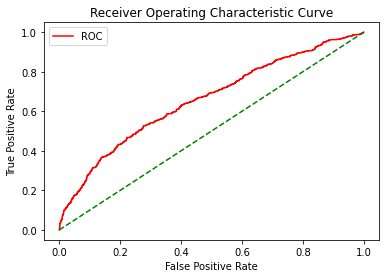

In [ ]:
prob = lr.predict_proba(val_X)
prob = prob[:, 1]
fper, tper, thresholds = roc_curve(val_y, prob)
plot_roc_curve(fper, tper)

In [ ]:
pred_proba_df = pd.DataFrame(lr.predict_proba(val_X))
threshold_list = [0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,.7,.75,.8,.85,.9,.95,.99]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    val_y_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_accuracy = metrics.accuracy_score(val_y.values.reshape(val_y.values.size,1),
                                           val_y_pred.iloc[:,1].values.reshape(val_y_pred.iloc[:,1].values.size,1))
    print('Our testing accuracy is {}'.format(test_accuracy))

    print(confusion_matrix(val_y['2_won'].values.reshape(val_y['2_won'].values.size,1),
                           val_y_pred.iloc[:,1].values.reshape(val_y_pred.iloc[:,1].values.size,1)))


******** For i = 0.05 ******
Our testing accuracy is 0.5335
[[143 891]
 [ 42 924]]

******** For i = 0.1 ******
Our testing accuracy is 0.5795
[[322 712]
 [129 837]]

******** For i = 0.15 ******
Our testing accuracy is 0.6035
[[454 580]
 [213 753]]

******** For i = 0.2 ******
Our testing accuracy is 0.6125
[[589 445]
 [330 636]]

******** For i = 0.25 ******
Our testing accuracy is 0.6225
[[694 340]
 [415 551]]

******** For i = 0.3 ******
Our testing accuracy is 0.6205
[[766 268]
 [491 475]]

******** For i = 0.35 ******
Our testing accuracy is 0.618
[[835 199]
 [565 401]]

******** For i = 0.4 ******
Our testing accuracy is 0.6115
[[878 156]
 [621 345]]

******** For i = 0.45 ******
Our testing accuracy is 0.61
[[927 107]
 [673 293]]

******** For i = 0.5 ******
Our testing accuracy is 0.592
[[949  85]
 [731 235]]

******** For i = 0.55 ******
Our testing accuracy is 0.5795
[[966  68]
 [773 193]]

******** For i = 0.6 ******
Our testing accuracy is 0.5715
[[989  45]
 [812 154]]

*

In [21]:
pred_proba_df = pd.DataFrame(lr.predict_proba(val_X))

In [ ]:
max_value = max(pred_proba_df[1])
max_index = pred_proba_df[1].to_list().index(max_value)

In [ ]:
min_value = min(pred_proba_df[1])
min_index = pred_proba_df[1].to_list().index(min_value)

In [ ]:
max_value

0.9856101458485946

In [ ]:
max_index

1715

In [ ]:
sample_out_of_bag.iloc[1715]

2_won                              1.000000
individual_hitpoint_diff        -125.833333
avg_cards_level_diff               3.875000
horde_tower_damage_diff          -88.000000
attack_radius_diff                -5.400000
attack_speed_diff                  0.250000
speed_diff                         5.000000
instant_air_damage_diff          -69.333333
instant_tower_damage_diff        -44.000000
individual_ground_damage_diff     -0.900000
individual_tower_damage_diff     222.000000
Name: 1897, dtype: float64

In [ ]:
min_value

0.0032258527819718666

In [ ]:
min_index

127

In [ ]:
sample_out_of_bag.iloc[127]

2_won                              0.000000
individual_hitpoint_diff        -310.333333
avg_cards_level_diff              -3.250000
horde_tower_damage_diff          -13.000000
attack_radius_diff                 1.400000
attack_speed_diff                 -0.050000
speed_diff                        -5.000000
instant_air_damage_diff          247.333333
instant_tower_damage_diff       -119.833333
individual_ground_damage_diff      0.000000
individual_tower_damage_diff     -49.500000
Name: 470374, dtype: float64

In [34]:
sample_out_of_bag.iloc[1728]

2_won                              0.000000
individual_hitpoint_diff          38.328571
avg_cards_level_diff              -1.375000
horde_tower_damage_diff          162.000000
attack_radius_diff                 0.800000
attack_speed_diff                 -0.733333
speed_diff                        20.000000
instant_air_damage_diff         -159.250000
instant_tower_damage_diff        540.114286
individual_ground_damage_diff    111.050000
individual_tower_damage_diff     124.600000
Name: 668652, dtype: float64

In [30]:
pred_proba_df.head()

,0,1
1700,0.631329,0.368671
1701,0.742587,0.257413
1702,0.812797,0.187203
1703,0.865307,0.134693
1704,0.857134,0.142866
1705,0.254216,0.745784
1706,0.310703,0.689297
1707,0.811690,0.188310
1708,0.699143,0.300857
1709,0.970209,0.029791
